In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from scipy import ndimage
import os
import io

In [3]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from tensorflow.keras import optimizers

In [4]:
train_dataset = h5py.File('train_catvnoncat.h5' , 'r')
train_features = np.array(train_dataset["train_set_x"][:])
train_labels = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_features = np.array(test_dataset["test_set_x"][:]) 
test_labels = np.array(test_dataset["test_set_y"][:]) 

classes = ['not-cat' , 'cat']


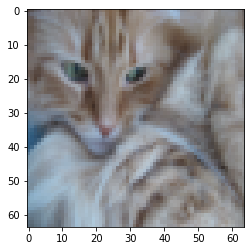

In [5]:
plt.imshow(train_features[2])

In [6]:
train_labels = to_categorical(train_labels,2)
test_labels = to_categorical(test_labels,2)

In [7]:
print(train_features.shape)
print(train_labels.shape)

(209, 64, 64, 3)
(209, 2)


DEFINING GENERATOR


In [8]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

TRAINING SET GENERATOR

In [9]:
train_generator = datagen.flow(train_features, train_labels)

VALIDATION SET GENERATOR

In [10]:
test_generator = datagen.flow(test_features, test_labels)

GETTING VGG

In [13]:
vgg_model=VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))

In [14]:
model = Sequential()
for layer in vgg_model.layers[:-1]:
    model.add(layer)

In [15]:
for layer in model.layers:
    layer.trainable = False
model.add(Flatten())
model.add(Dense(units=2,activation='softmax'))

In [16]:
#model.summary()

MODEL COMPILING

In [17]:
opt = optimizers.Adam(learning_rate=0.01)

In [18]:
model.compile(optimizer = opt , loss='categorical_crossentropy' , metrics = ['accuracy'] )

print(train_labels.shape)
print(test_labels.shape)

(209, 2)
(50, 2)


OUTPUT WITH DATA AUGMENTATION

In [19]:
model.fit(train_generator,epochs=12,verbose=1, steps_per_epoch=5 , validation_data=test_generator)

Epoch 1/12
5/5 [==============================] - 7s 1s/step - loss: 12.6633 - accuracy: 0.7310 - val_loss: 6.9580 - val_accuracy: 0.9400
Epoch 2/12
5/5 [==============================] - 7s 1s/step - loss: 9.4129 - accuracy: 0.8621 - val_loss: 15.4900 - val_accuracy: 0.9400
Epoch 3/12
5/5 [==============================] - 7s 1s/step - loss: 1.1512 - accuracy: 0.9655 - val_loss: 15.5244 - val_accuracy: 0.9000
Epoch 4/12
5/5 [==============================] - 8s 2s/step - loss: 5.1733 - accuracy: 0.9625 - val_loss: 29.5314 - val_accuracy: 0.8800
Epoch 5/12
5/5 [==============================] - 7s 1s/step - loss: 4.4722 - accuracy: 0.9517 - val_loss: 44.1472 - val_accuracy: 0.8200
Epoch 6/12
5/5 [==============================] - 7s 1s/step - loss: 4.7095 - accuracy: 0.9563 - val_loss: 11.5184 - val_accuracy: 0.9200
Epoch 7/12
5/5 [==============================] - 7s 1s/step - loss: 2.8027 - accuracy: 0.9688 - val_loss: 28.1069 - val_accuracy: 0.8800
Epoch 8/12
5/5 [==================

In [20]:
model.save('data_augmented.h5')

OUTPUT WHEN RAN WITHOUT DATA AUGMENTATION

In [21]:
#---------- THIS PROCESS REDUCES ACCURACY TO 60 % --------------
# train_features = train_features / 255 
# test_features = test_features / 255

In [22]:
train_features=preprocess_input(train_features)
test_features=preprocess_input(test_features)

In [23]:
model.fit(train_features,train_labels,epochs=4,verbose=1,batch_size=10, validation_data=(test_features,test_labels) , shuffle=True)

Epoch 1/4
21/21 [==============================] - 11s 517ms/step - loss: 0.1998 - accuracy: 0.9904 - val_loss: 27.0801 - val_accuracy: 0.9200
Epoch 2/4
21/21 [==============================] - 11s 502ms/step - loss: 0.7341 - accuracy: 0.9904 - val_loss: 20.5748 - val_accuracy: 0.9200
Epoch 3/4
21/21 [==============================] - 10s 499ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 20.5396 - val_accuracy: 0.9200
Epoch 4/4
21/21 [==============================] - 10s 499ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 20.5360 - val_accuracy: 0.9200


In [24]:
model.save('regular.h5')

LOADING THE MODEL

In [1]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model

import cv2
import numpy as np


In [11]:
# IMAGE PREPROCESSING
def preprocess_image(name):
    # img = cv2.imread(name)
    img = load_img(name, target_size=(64,64))
    res = img_to_array(img)
    # res = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    preprocessed_image = preprocess_input(img)
    samples = np.expand_dims(preprocessed_image, 0)

    return samples

In [12]:
image = preprocess_image('cat.png')
image2 = preprocess_image('not_cat.png')

TypeError: 'Image' object is not subscriptable

In [4]:
reconstructed_model = load_model("data_augmented.h5")

In [5]:
prediction1 = reconstructed_model.predict(image)
prediction2 = reconstructed_model.predict(image2)


In [6]:
print(prediction1,prediction2)

[[0. 1.]] [[1. 0.]]
